In [1]:
import pandas as pd

In [4]:
df = pd.read_csv('C:\\D盘\\COVID-19 rumors-debunking\\biterm\\data\\data_with_topic_labels.csv')

C:\Users\qqcom\AppData\Local\Temp\ipykernel_17192\3548434094.py:1: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:\\D盘\\COVID-19 rumors-debunking\\biterm\\data\\data_with_topic_labels.csv')


In [5]:
df.columns

Index(['博文ID', '博文链接', '博文内容', '博文关联话题', '博文发布时间', '博文图片链接', '博文转发量', '博文评论量',
       '博文点赞量', '博主ID', '博主名称', '博主链接', '博主图像', '博主简介', '博主关注数', '博主粉丝数',
       '博主博文数', '博主性别', '博主认证信息', '原文博文ID', '原文博文链接', '原文博文内容', '原文博文关联话题',
       '原文博文发布时间', '原文博文图片链接', '原文博文转发量', '原文博文评论量', '原文博文点赞量', '原文博主ID',
       '原文博主名称', '原文博主链接', '原文博主图像', '原文博主简介', '原文博主关注数', '原文博主粉丝数', '原文博主博文数',
       '原文博主性别', '原文博主认证信息', 'pred_classify', 'cut', 'label'],
      dtype='object')

## Social network analysis

In [6]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager

In [7]:
data = df[['博文内容','博主名称','原文博主名称']]

In [8]:
content = df.loc[16,'博文内容']
blogger = df.loc[16,'博主名称']
original_blogger = df.loc[16,'原文博主名称']
print(content)
print(blogger)
print(original_blogger)

//@东条瞳-://:中 国 速 度//@yellow想名很头疼:最右已经无了//@一位爱好嗑瓜子儿的仙姑 :我本来没打算相信，但你这么迅速地找到当事人来辟谣//@福福老哥 :不是这也太把我们当傻子看了吧！如果是无意入镜的市民群众，你们又是怎么找到她并采访到她的？这条应该可以算作本年度最搞笑新闻了吧哈哈
小猫家的小毛
中国新闻网


In [9]:
G = nx.DiGraph()
content = df.loc[16,'博文内容']
blogger = df.loc[16,'博主名称']
original_blogger = df.loc[16,'原文博主名称']

G.add_node(original_blogger)
source = original_blogger
target = None
if '//@' in content:
    splits = content.split('//@')[1:]
    for i in range(len(splits)-1, -1, -1):
        target = splits[i].split(':')[0].strip()
        if target == '':
            continue
        G.add_node(target)
        G.add_edge(source, target)  # Reverse the edge direction
        source = target

G.add_node(blogger)
if source is not None:
    G.add_edge(source, blogger)

edges = list(G.edges)
print("传播关系：")
for edge in edges:
    print(edge)

传播关系：
('中国新闻网', '福福老哥')
('福福老哥', '一位爱好嗑瓜子儿的仙姑')
('一位爱好嗑瓜子儿的仙姑', 'yellow想名很头疼')
('yellow想名很头疼', '东条瞳-')
('东条瞳-', '小猫家的小毛')


In [10]:
G = nx.DiGraph()
for index, row in data.iterrows():
    content = str(row['博文内容'])
    blogger = row['博主名称']
    original_blogger = row['原文博主名称']

    G.add_node(original_blogger)
    source = original_blogger
    target = None
    if '//@' in content:
        splits = content.split('//@')[1:]
        for i in range(len(splits)-1, -1, -1):
            target = splits[i].split(':')[0].strip()
            if target == '':
                continue
            G.add_node(target)
            if source != target:
                G.add_edge(source, target)  # Reverse the edge direction
            source = target

    G.add_node(blogger)
    if source is not None and source != blogger:
        G.add_edge(source, blogger)


print("节点数:", G.number_of_nodes())
print("边数:", G.number_of_edges())

节点数: 89423
边数: 106067


In [11]:
degrees = dict(G.degree())
sorted_degrees = sorted(degrees.items(), key=lambda x: x[1], reverse=True)

top_10_nodes = [node for node, _ in sorted_degrees[:12]]
df_top_nodes = pd.DataFrame(columns=['node','out_degree','in_degree'])
# 计算前10个节点的出度和入度
for node in top_10_nodes:
    in_degree = G.in_degree(node)
    out_degree = G.out_degree(node)
    df_top_nodes = pd.concat([df_top_nodes, pd.DataFrame({'node': [node], 'in_degree': [in_degree], 'out_degree': [out_degree]})], ignore_index=True)

df_top_nodes= df_top_nodes.drop([1,6])
df_top_nodes= df_top_nodes.reset_index(drop=True)
df_top_nodes

,node,out_degree,in_degree
0,微博辟谣,2940,896
1,人民日报,1159,0
2,来去之间,867,74
3,中国新闻网,743,0
4,央视新闻,732,1
5,sunwear,630,22
6,开水族馆的生物男,523,47
7,财经网,478,0
8,观察者网,433,2
9,暗室四知,423,1


In [12]:
for i in range(len(df_top_nodes)):
    node = df_top_nodes.loc[i, 'node']
    matching_row = df[df['原文博主名称'] == node]
    if not matching_row.empty:
        certification = matching_row.iloc[0]['原文博主认证信息']
        df_top_nodes.loc[i, 'certification'] = certification

df_top_nodes.to_csv('top_nodes.csv',encoding='utf-8-sig', index=False)

In [26]:
top_nodes = [node for node, _ in sorted_degrees[:500]]  # 只显示前x个度的节点
subgraph = G.subgraph(top_nodes)  # 提取子图
nx.write_gexf(subgraph, "C:\\D盘\\COVID-19 rumors-debunking\\network_analysis\\graph.gexf")

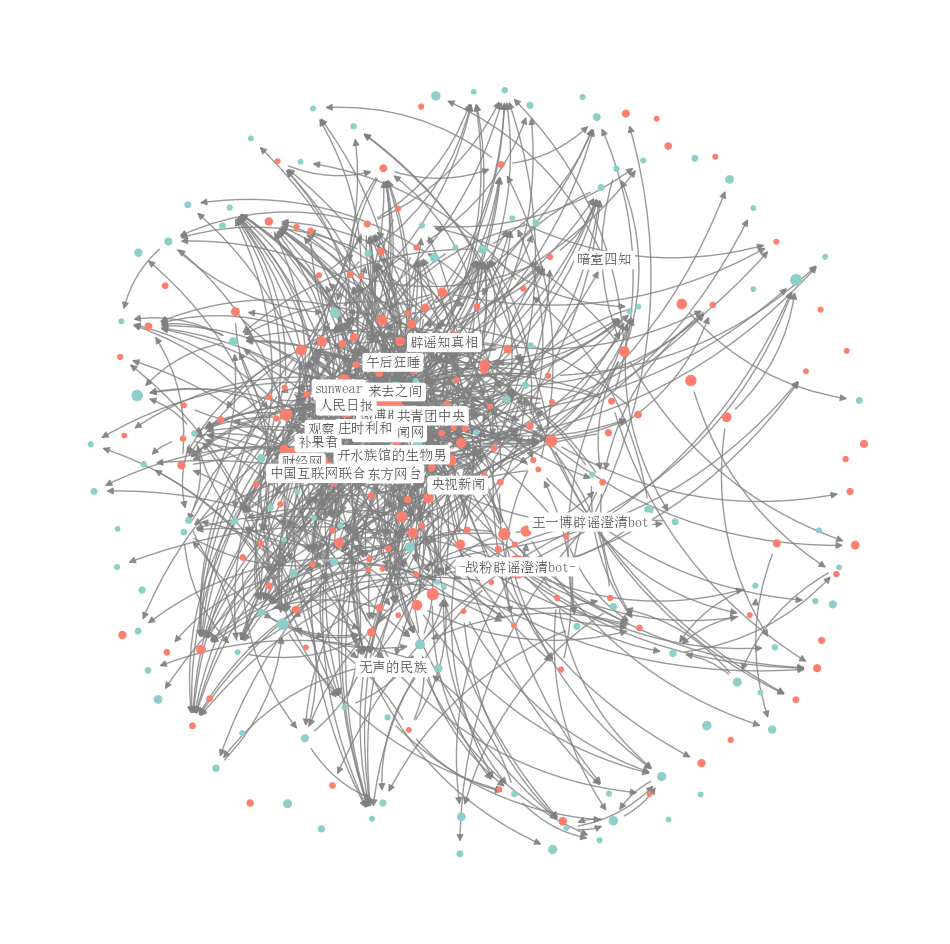

In [24]:
# 设置节点的属性
node_colors = []
node_sizes = []
for node in subgraph.nodes:
    if node in df['原文博主名称'].values:
        node_colors.append("#FA7F6F")  # 将"original_blogger"节点设置为红色
    else:
        node_colors.append("#8ECFC9")  # 其他节点设置为蓝色
    node_sizes.append(degrees[node]/5)
        
pos = nx.fruchterman_reingold_layout(subgraph, k=0.3, iterations=50)  # 布局算法

plt.figure(figsize=(12, 12))  # 设置图形的大小

font_path = 'simsun.ttf'  # 替换中文字体文件路径
prop = font_manager.FontProperties(fname=font_path)

# 绘制节点和边
nx.draw_networkx_nodes(subgraph, pos, node_color=node_colors, node_size=node_sizes)
nx.draw_networkx_edges(subgraph, pos, edge_color='gray', alpha=0.8, connectionstyle='arc3,rad=0.2')

# 绘制节点标签
top_20_nodes = top_nodes[:20]
node_labels = {node: node for node in top_20_nodes}
nx.draw_networkx_labels(subgraph, pos, labels=node_labels, font_size=10,font_family=prop.get_name(),font_color='black', bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2'), alpha=0.7)

# 手动调整标签位置
label_pos = {}
for node, (x, y) in pos.items():
    label_pos[node] = (x, y + 6)

#nx.draw_networkx_labels(subgraph, label_pos, labels=node_labels, font_size=10, font_family=prop.get_name(), font_color='black', bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2'), alpha=0.7)

# 隐藏坐标轴
plt.axis('off')

# 显示图形
plt.show()


In [ ]:
plt.savefig('network.png')

<Figure size 640x480 with 0 Axes>